In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn import model_selection, linear_model
from sklearn.impute import KNNImputer, SimpleImputer
import util

In [2]:
# Path: data-processing.ipynb
# Read in the data
df = pd.read_csv('data/application_train.csv')
df.head(15)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Removes columns we first deemed are useless
util.defaultClean(df)
target = df["TARGET"]
df.drop(columns = ["TARGET", "SK_ID_CURR"], inplace=True)

In [4]:
# All columns with NaNs
df2 = df.loc[:, df.isnull().any()]
print("numCols: ", len(df2.columns))
df2.columns

numCols:  67


Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

In [5]:
# Calculates percentage of NaNs alongside data type of column
percentNull = {}
for col in df.columns:
    percent = (len(df[df[col].isnull()]))/len(df)
    if percent > 0:
        percentNull[col] = (df.dtypes[col], percent)
percentNull

{'AMT_ANNUITY': (dtype('float64'), 3.9022994299390916e-05),
 'AMT_GOODS_PRICE': (dtype('float64'), 0.0009040327012692228),
 'NAME_TYPE_SUITE': (dtype('O'), 0.004201475719567756),
 'OWN_CAR_AGE': (dtype('float64'), 0.6599081008484249),
 'OCCUPATION_TYPE': (dtype('O'), 0.31345545362604915),
 'CNT_FAM_MEMBERS': (dtype('float64'), 6.503832383231819e-06),
 'EXT_SOURCE_1': (dtype('float64'), 0.5638107254699832),
 'EXT_SOURCE_2': (dtype('float64'), 0.0021462646864665006),
 'EXT_SOURCE_3': (dtype('float64'), 0.19825307062186392),
 'APARTMENTS_AVG': (dtype('float64'), 0.5074972927797705),
 'BASEMENTAREA_AVG': (dtype('float64'), 0.5851595552679416),
 'YEARS_BEGINEXPLUATATION_AVG': (dtype('float64'), 0.48781019215572774),
 'YEARS_BUILD_AVG': (dtype('float64'), 0.6649778381911542),
 'COMMONAREA_AVG': (dtype('float64'), 0.6987229725115525),
 'ELEVATORS_AVG': (dtype('float64'), 0.532959796560123),
 'ENTRANCES_AVG': (dtype('float64'), 0.503487680115508),
 'FLOORSMAX_AVG': (dtype('float64'), 0.4976082

In [6]:
# Shows all rows where a certain column has NaNs
df[df['EXT_SOURCE_2'].isnull()]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
329,Cash loans,M,N,N,2,157500.0,239850.0,25447.5,225000.0,Unaccompanied,...,0.0,1.0,0.0,-344.0,NaN,NaN,NaN,NaN,NaN,NaN
349,Cash loans,F,N,Y,0,81000.0,276277.5,21825.0,238500.0,Unaccompanied,...,0.0,1.0,0.0,-275.0,NaN,NaN,NaN,NaN,NaN,NaN
617,Cash loans,F,N,Y,0,180000.0,533668.5,22738.5,477000.0,Unaccompanied,...,1.0,1.0,1.0,-364.0,0.0,0.0,0.0,0.0,0.0,2.0
1028,Cash loans,F,Y,Y,0,121500.0,909000.0,36180.0,909000.0,Unaccompanied,...,0.0,2.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,5.0
1520,Cash loans,M,Y,Y,0,225000.0,269550.0,21294.0,225000.0,Unaccompanied,...,0.0,2.0,0.0,-1868.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305775,Cash loans,F,N,N,1,225000.0,566055.0,18387.0,472500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
306208,Cash loans,M,N,Y,0,112500.0,562491.0,23832.0,454500.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
306235,Cash loans,F,N,Y,0,112500.0,343800.0,16155.0,225000.0,Unaccompanied,...,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
307029,Cash loans,F,Y,N,2,153000.0,808650.0,26217.0,675000.0,Unaccompanied,...,0.0,0.0,0.0,-1110.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Y'ALL, WE'RE DUMB AS SHIT. Check this out:
col_descriptions = pd.read_csv('data/HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
col_descriptions.head(20)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


| Column Name | DType | What it Means | How to Handle |
| --- | --- | --- | --- |
| AMT_ANNUITY | float | Monthly payment for the loan | I would find the mean of AMT_ANNUITY/AMT_CREDIT and then multiply that mean ratio by the AMT_CREDIT for the rows that don't have a NaN AMT_ANNUITY |
| AMT_GOODS_PRICE | float | Price of the Good that people get a loan for | Most times, AMT_CREDIT is either slightly greater than or equal to AMT_GOODS_PRICE, so I would just set NaNs in AMT_GOODS_PRICE to whatever the AMT_CREDIT is for that row|
| NAME_TYPE_SUITE | String | Who was accompanying the person when they were applying for the loan | Either just assume they were unnacompanied, use the mode, or use K-Means |
| OWN_CAR_AGE | float | Age of the car they owned | Fill NaNs w/ 0 or -1, since a person without a car will have a NaN here. Filling with 0 as it could conflate with those who have a brand new car, but -1 could be mistinterpreted as a very very new car or something |
| OCCUPATION_TYPE | String | What the person's occupation is | Not sure, probably should leave to K-Means |
| CNT_FAM_MEMBERS | float | How many family members the person has | K-Means or mode |
| EXT_SOURCE_1 | float | Normalized score from external database | Linear Regression/Use other two scores. There are situations in which only one score is present, and very few where no external scores are present. |
| EXT_SOURCE_2 | float | Normalized score from external database | Linear Regression/Use other two scores. There are situations in which only one score is present, and very few where no external scores are present. |
| EXT_SOURCE_3 | float | Normalized score from external database | Linear Regression/Use other two scores. There are situations in which only one score is present, and very few where no external scores are present. |
| OBS_30_CNT_SOCIAL_CIRCLE | float | Amount of people in person's social circle who were observed with a possible 30 DPD (Days past due) default | NaN means there was no observation, so I would make an "assumption" of 0, but you could also use K-Means I think |
| DEF_30_CNT_SOCIAL_CIRCLE | float | Amount of people in person's social circle who defaulted with a  30 DPD (Days past due) | NaN means there was no observation, so I would make an "assumption" of 0, but you could also use K-Means I think |
| OBS_60_CNT_SOCIAL_CIRCLE | float | Amount of people in person's social circle who were observed with a possible 60 DPD (Days past due) default | NaN means there was no observation, so I would make an "assumption" of 0, but you could also use K-Means I think |
| DEF_60_CNT_SOCIAL_CIRCLE | float | Amount of people in person's social circle who defaulted with a 60 DPD (Days past due) | NaN means there was no observation, so I would make an "assumption" of 0, but you could also use K-Means I think |
| DAYS_LAST_PHONE_CHANGE | float | How many days before applying did the client change their phone | I think there's only one NaN so we can set it to 0 |
| AMT_REQ_CREDIT_BUREAU_HOUR | float | Amount of enquiries the client had with the Credit Bureau one hour before application | If there's no data, we probably should assume 0. We can't really guess at how many enquiries a client had and when they had them |
| AMT_REQ_CREDIT_BUREAU_DAY | float | Amount of enquiries the client had with the Credit Bureau one day before application | If there's no data, we probably should assume 0. We can't really guess at how many enquiries a client had and when they had them |
| AMT_REQ_CREDIT_BUREAU_WEEK | float | Amount of enquiries the client had with the Credit Bureau one week before application | If there's no data, we probably should assume 0. We can't really guess at how many enquiries a client had and when they had them |
| AMT_REQ_CREDIT_BUREAU_MON | float | Amount of enquiries the client had with the Credit Bureau one month before application | If there's no data, we probably should assume 0. We can't really guess at how many enquiries a client had and when they had them |
| AMT_REQ_CREDIT_BUREAU_QRT | float | Amount of enquiries the client had with the Credit Bureau three months before application | If there's no data, we probably should assume 0. We can't really guess at how many enquiries a client had and when they had them |
| AMT_REQ_CREDIT_BUREAU_YEAR | float | Amount of enquiries the client had with the Credit Bureau one year before application | If there's no data, we probably should assume 0. We can't really guess at how many enquiries a client had and when they had them |


# Data Preprocessing

In [8]:
# All rows where AMT_ANNUITY is NaN
df_annuity = df[df["AMT_ANNUITY"].notnull()]
# Average of non NaN AMT_ANNUITY
numerator = df_annuity["AMT_ANNUITY"].mean()
# Average of non NaN AMT_CREDIT
denominator = df_annuity["AMT_CREDIT"].mean()
# Average ratio of AMT_ANNUITY / AMT_CREDIT
ratio = numerator / denominator
# Set Nulls in AMT_ANNUITY to ratio multiplied by the relevant AMT_CREDIT index
df["AMT_ANNUITY"] = df["AMT_ANNUITY"].fillna(ratio * df["AMT_CREDIT"])

 # Set Nulls in AMT_GOODS_PRICE to the relevant AMT_CREDIT index
df["AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"].fillna(df["AMT_CREDIT"])

# Columns where we fill null with 0
cols = ["OWN_CAR_AGE", "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
        "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "DAYS_LAST_PHONE_CHANGE",
        "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
zero_cols = ["OWN_CAR_AGE", "DAYS_LAST_PHONE_CHANGE", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
# Set Nulls in zero cols to 0
for col in zero_cols:
        df[col] = df[col].fillna(0)

## Handle Categorical Data

In [9]:
str_columns = df.select_dtypes(['string', "object"]).columns
df[str_columns] = df[str_columns].astype("category")
cat_columns = df.select_dtypes(['category']).columns
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes + 1)
df = util.onehot_categorical_columns(df, cat_columns)

In [10]:
df.head()

In [ ]:
imputer = SimpleImputer(missing_values=np.NaN, strategy = "constant", fill_value=0)
df[:] = imputer.fit_transform(df)

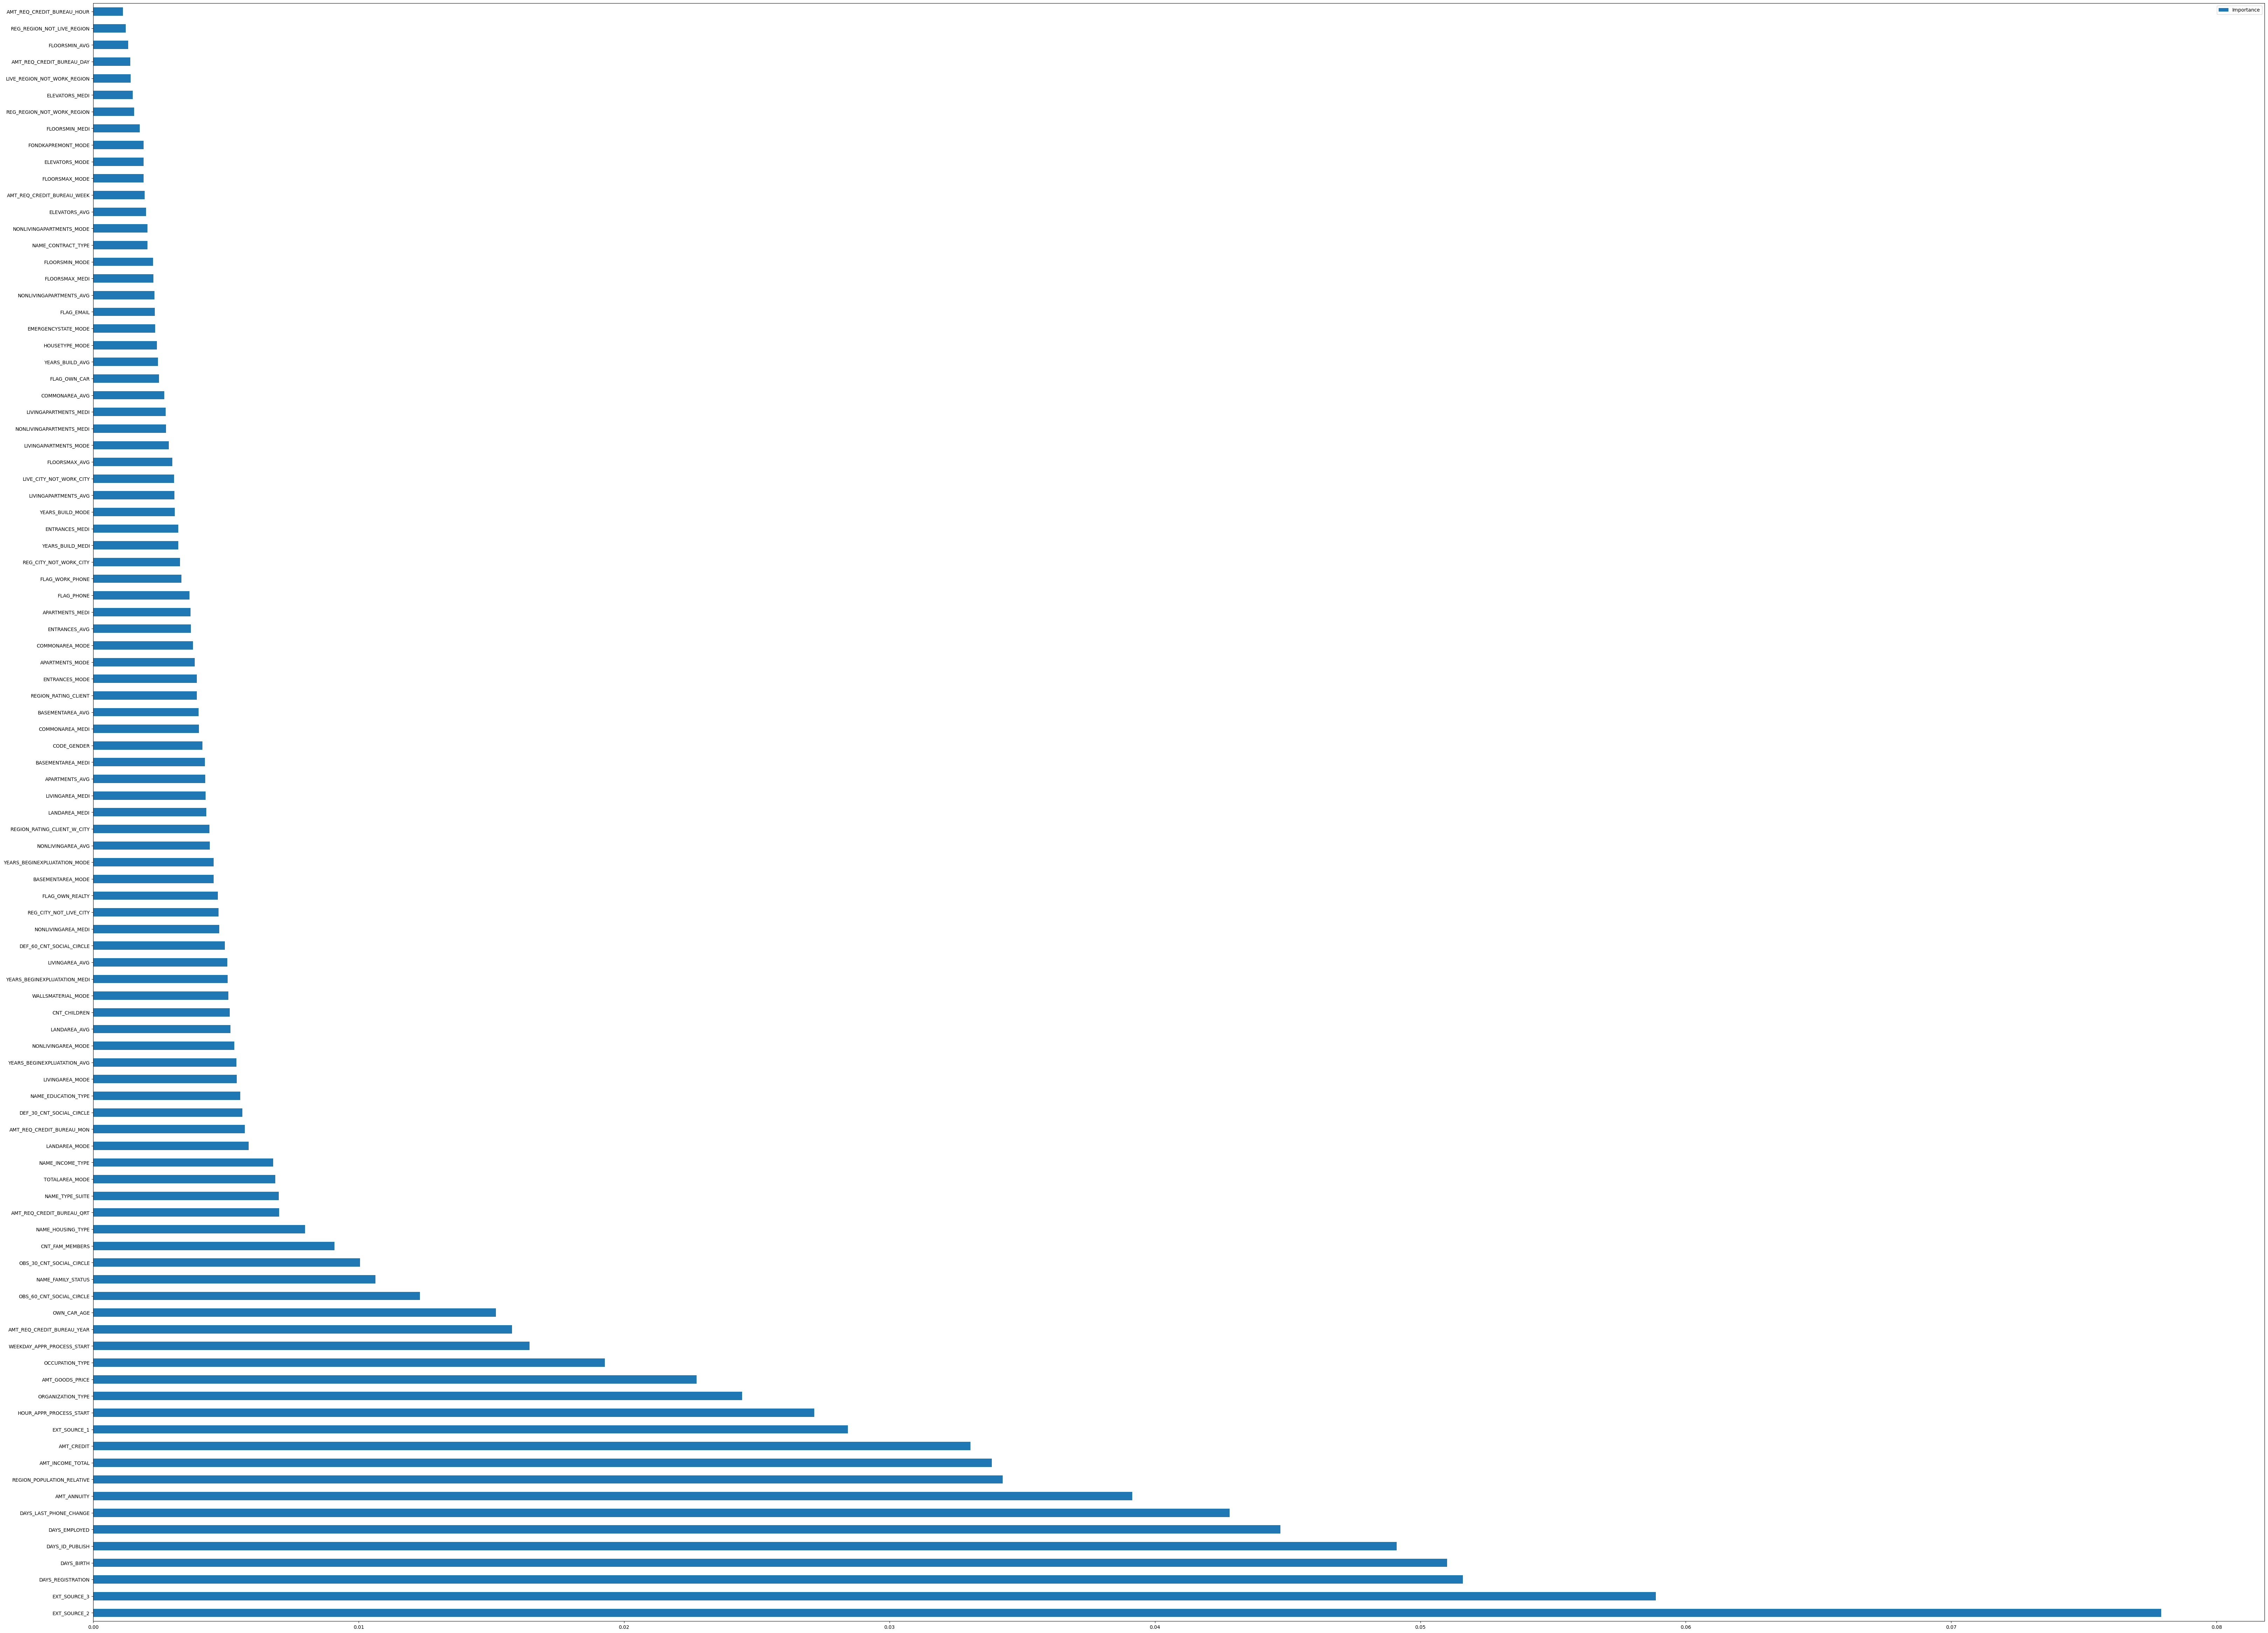

In [11]:
df.columns

In [ ]:
from get_feature_importance import get_feature_imp
get_feature_imp(df, target)

In [12]:
# df.to_csv("cleaned_data.csv")

In [13]:
output = util.run_pca(df, 40)

In [14]:


train_X, test_X, train_y, test_y = model_selection.train_test_split(output.to_numpy(), target.to_numpy(), test_size=0.25, shuffle=True, stratify=target.to_numpy())
print("training size:", len(train_X))
print("testing size:", len(test_X))

training size: 230633
testing size: 76878


In [15]:
# non_null_ext_df =  df.dropna(subset=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])
# # non_null_ext_df = df.fillna(value={'EXT_SOURCE_1': 0.5, 'EXT_SOURCE_2': 0.5, 'EXT_SOURCE_3': 0.5})
# print(non_null_ext_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
# print("# points that have all 3 non-null ext sources:", len(non_null_ext_df))
# non_null_ext_sample = non_null_ext_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sample(frac=0.001)
# # extsrc_regr = linear_model.LinearRegression().fit()
# ext_src_fig = px.scatter_3d(non_null_ext_sample, x='EXT_SOURCE_1', y='EXT_SOURCE_2', z='EXT_SOURCE_3')
# ext_src_fig.show()
# print("correlation between sources 1 and 2 compared to source2\n",
#       non_null_ext_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr()['EXT_SOURCE_2'][:], sep='')

baseline balanced-accuracy-score: 0.5
Running Support Vector Classifier ....


/Users/reeteshsudhakar/miniconda3/envs/ml-project/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM balanced accuracy: 0.6360019796327887


/Users/reeteshsudhakar/miniconda3/envs/ml-project/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


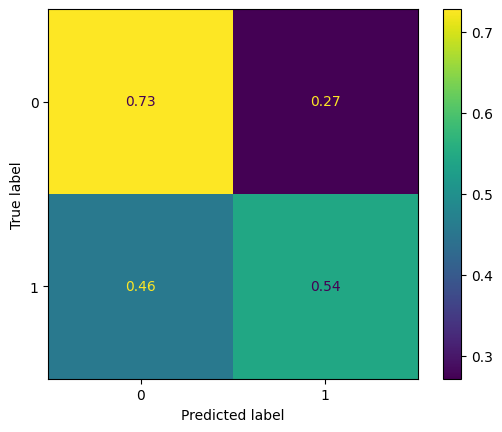

Running Logistic Classifier ....
Logistic Classifier balanced accuracy: 0.5330325081054208


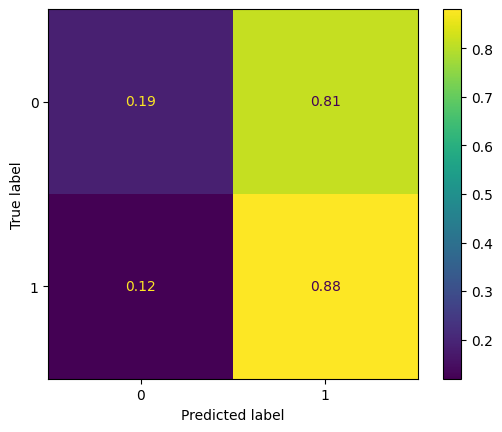

In [17]:
from classifier import run_and_compare
run_and_compare(train_X, train_y, test_X, test_y)